# Data Retreival

In [66]:
import requests
import json
import pandas as pd

# This token no longer works; you should replace it with your own

bearer_token =  'AAAAAAAAAAAAAAAAAAAAAIT7MAEAAAAAfyfX5cMHYIyEKSZMpuO%2BVDuuaAY%3DHs6Ug8qwXtWTZb8KafniU4qeeOhGqNfU8bu2NUR5vYBptqzfaj'
#'AAAAAAAAAAAAAAAAAAAAAJ69MQEAAAAARlvzDHdk01czVuqJY3gdm%2BhSzIY%3DUYGvgaTbF7yV4AspZaCoAXySfpVIN75R2TQIvc6lDJ4UrLqUY8'
#'AAAAAAAAAAAAAAAAAAAAADAZMQEAAAAAWXJrb4aADbRj6rqxQ8APG8n5mj8%3DPIZGuNSoQ7Yyj8TNQKy6fVwA29aV0qh448gVVgOe5DWqHEq8JC'
headers = {'Authorization':('Bearer '+ bearer_token)}

# In this example, only those tweets with photos/images are stored

n = 100                           # The total number of tweets we want
max_results = 100                 # The number of tweets to pull per request; must be between 10 and 100
total_retrieved = 0               # To keep track of when to stop
next_token = ""                   # Must be empty on first iteration
search_term = "spieth"  # To form an advanced query, see here: https://twitter.com/search-advanced?lang=en
since_id = "1374234241322860544"  # The id of the oldest tweet you want to retrieve

# Create the empty DataFrame with the columns you want
df = pd.DataFrame(columns=['id', 'retweets', 'likes', 'replies', 'quotes', 'url', 'text', 'lang', 'sensitive', 'has_media'])

df.set_index('id', inplace=True)

# stop when we have n results
while total_retrieved < n:

    # the first time through the loop, we do not need the next_token parameter
    if next_token == "":
        url = f'https://api.twitter.com/2/tweets/search/recent?query={search_term}&max_results={max_results}' #'&since_id={since_id}'
    else:
        url = f'https://api.twitter.com/2/tweets/search/recent?query={search_term}&max_results={max_results}&next_token={next_token}' #'&since_id={since_id}'

    # These are the extra parameters we will add to the querystring; we won't store them all though; just want you to see what's possible
    url += f'&tweet.fields=attachments,public_metrics,text,lang,created_at,possibly_sensitive'
    url += f'&expansions=attachments.media_keys'
    url += f'&media.fields=media_key,type,url'

        
    # print(f'URL: {url}')
    # make the request to the Twitter API Recent Search endpoint
    response = requests.request("GET", url, headers=headers)
    try:  # Just in case we get an error
        json_data = json.loads(response.text)
    except:
        print(response.text)

    if not 'data' in json_data:
        print(json_data)

    #print(json_data)
    #exit()

    for tweet in json_data['data']:
        media_key = ""  # Reset to empty each time through the loop so that we can use it for a condition later

        # Store the data into variables
        tweet_id = tweet['id']
        retweet_count = tweet['public_metrics']['retweet_count']
        like_count = tweet['public_metrics']['like_count']
        reply_count = tweet['public_metrics']['reply_count']
        quote_count = tweet['public_metrics']['quote_count']
        lang = tweet['lang']
        possibly_sensitive = tweet['possibly_sensitive']
        image_url = ""
        text = tweet['text']

        # Find out if there is media
        if 'attachments' in tweet:
            if 'media_keys' in tweet['attachments']:
                media_key = tweet['attachments']['media_keys'][0]

        has_media = False
        # If there is a media key in this tweet, iterate through tweet['includes']['media'] until we find it
        if media_key != "":
            for media in json_data['includes']['media']:
                if media['media_key'] == media_key: # Only if the media_key matches the one we stored
                    has_media = True
                    if media['type'] == 'photo':      # Only if it is a photo; ignore videos
                        image_url = media['url']        # Store the url in a variable

                        # Only iterate if a photo is found
                        total_retrieved += 1

                        # Only add the record in the DataFrame if a photo is found
                        #df.loc[tweet_id] = [retweet_count, like_count, image_url, text]
                        df.loc[tweet_id] = [retweet_count, like_count, reply_count, quote_count, image_url, text, lang, possibly_sensitive, has_media]
                        break

 
    # keep track of where to start next time, but quit if there are no more results
    try:
        next_token = json_data['meta']['next_token']
    except:
        break  

df.to_csv('twitter.csv')
df.head()

,retweets,likes,replies,quotes,url,text,lang,sensitive,has_media
id,,,,,,,,,
1377090096055263238,1,0,0,0,https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg,“Good vibes” finally circling around Jordan Sp...,en,False,True
1377084502418264075,1,14,0,1,https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg,🚨Jordan Spieth told Golf Channel that he’s loo...,en,False,True
1377028160496099330,0,0,0,0,https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg,@OsisAnnie @RobBoltonGolf @valerotxopen @PGATO...,en,False,True
1377009006892433413,0,0,0,0,https://pbs.twimg.com/media/ExweZP0WUAUoFyI.jpg,"AUSTIN, Texas (AP) - Jordan Spieth tapped in f...",en,False,True
1377007973806014464,0,0,0,0,https://pbs.twimg.com/media/Exwc-3eWUAARumh.png,Good to hear @JordanSpieth @UnderArmour soundi...,en,False,True


# Data Exploration

In [67]:
import pandas as pd
df = pd.read_csv('twitter.csv')

# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)
df.head()

(105, 10)


,id,retweets,likes,replies,quotes,url,text,lang,sensitive,has_media
0,1377090096055263238,1,0,0,0,https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg,“Good vibes” finally circling around Jordan Sp...,en,False,True
1,1377084502418264075,1,14,0,1,https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg,🚨Jordan Spieth told Golf Channel that he’s loo...,en,False,True
2,1377028160496099330,0,0,0,0,https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg,@OsisAnnie @RobBoltonGolf @valerotxopen @PGATO...,en,False,True
3,1377009006892433413,0,0,0,0,https://pbs.twimg.com/media/ExweZP0WUAUoFyI.jpg,"AUSTIN, Texas (AP) - Jordan Spieth tapped in f...",en,False,True
4,1377007973806014464,0,0,0,0,https://pbs.twimg.com/media/Exwc-3eWUAARumh.png,Good to hear @JordanSpieth @UnderArmour soundi...,en,False,True


In [68]:
df.dtypes

id           object
retweets      int64
likes         int64
replies       int64
quotes        int64
url          object
text         object
lang         object
sensitive      bool
has_media      bool
dtype: object

In [69]:
#df.drop(columns=['created_at'], inplace=True)
df.describe()

,retweets,likes,replies,quotes
count,105.000000,105.000000,105.000000,105.000000
mean,5.800000,24.838095,1.657143,0.457143
std,10.069375,86.053664,5.386644,1.829400
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,4.000000,7.000000,1.000000,0.000000
max,51.000000,702.000000,30.000000,16.000000


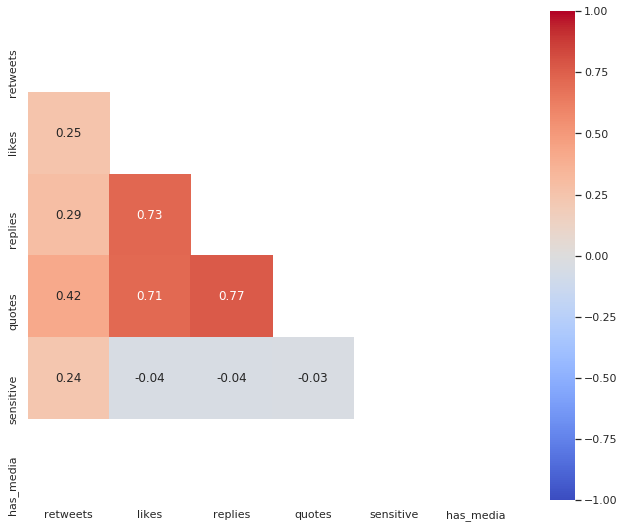

In [70]:
# Create a heatmap over a correlation table

import seaborn as sns
sns.set_style("whitegrid")
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.2f', 
      vmin=-1, vmax=1, center=0, cmap= 'coolwarm', 
      mask=matrix, square=True);

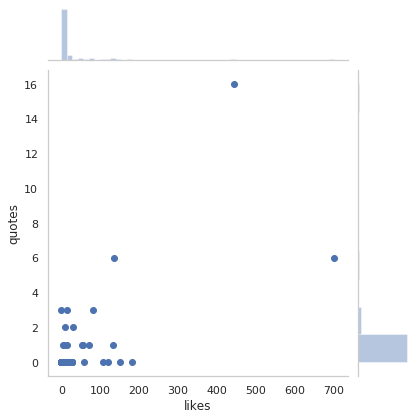

In [71]:
sns.set(color_codes=True)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.jointplot(x='likes', y='quotes', data=df);

# Text Preprocessing

In [72]:
!pip install --upgrade pip
!pip install pyLDAvis
!pip install pyLDAvis.gensim
!pip install bokeh
!pip install gensim
!pip install spacy
#!pip install logging
!pip install wordcloud
!pip install warnings
!pip install matplotlib
!pip install nltk
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install -U seaborn
!pip install translators --upgrade

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim
ERROR: No matching distribution found for pyLDAvis.gensim
ERROR: Could not find a version that satisfies the requirement warnings
ERROR: No matching distribution found for warnings
     |████████████████████████████████| 13.7 MB 5.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [73]:
import pandas as pd
df = pd.read_csv('twitter.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)
df.lang.value_counts()

(105, 10)


en     97
und     4
es      3
in      1
Name: lang, dtype: int64

In [74]:
import sys
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings, en_core_web_sm
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'co', 'https', 'http', 'twitter', 'amp', 'covid', 'gofundme']) # After reviewing the LDA, return to add words that you want to eliminate


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\\S*@\\S*\\s?', '', sent)  # remove emails
        sent = re.sub('\\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert each tweet to a list of cleaned words and add to a master list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
for tweet in data_words[:5]: # print the first :n tweet word lists
    print(tweet)

df['words'] = data_words
df.head()

['good', 'vibes', 'finally', 'circling', 'around', 'jordan', 'spieth', 'but', 'he', 'can', 'win', 'the', 'masters', 'on', 'that', 'alone', 'story', 'gt', 'gt', 'gt', 'https', 'co', 'ann', 'puvda', 'by', 'https', 'co', 'bpgfmiga']
['jordan', 'spieth', 'told', 'golf', 'channel', 'that', 'he', 'looking', 'to', 'fine', 'tune', 'the', 'game', 'this', 'week', 'ahead', 'of', 'the', 'masters', 'https', 'co', 'pzqjilmr']
['thats', 'good', 'looking', 'team', 'mine', 'is', 'similar', 'but', 'am', 'also', 'very', 'keen', 'on', 'sam', 'ryder', 'had', 'him', 'in', 'last', 'weeks', 'early', 'team', 'but', 'chickened', 'out', 'if', 'had', 'any', 'confidence', 'in', 'my', 'gut', 'would', 'put', 'him', 'in', 'ahead', 'of', 'spieth', 'https', 'co', 'wdzo', 'meujg']
['austin', 'texas', 'ap', 'jordan', 'spieth', 'tapped', 'in', 'for', 'bogey', 'to', 'win', 'the', 'masters', 'bent', 'over', 'briefly', 'and', 'then', 'straightened', 'with', 'smile', 'that', 'was', 'his', 'favorite', 'image', 'from', 'his', '

,id,retweets,likes,replies,quotes,url,text,lang,sensitive,has_media,words
0,1377090096055263238,1,0,0,0,https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg,“Good vibes” finally circling around Jordan Sp...,en,False,True,"[good, vibes, finally, circling, around, jorda..."
1,1377084502418264075,1,14,0,1,https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg,🚨Jordan Spieth told Golf Channel that he’s loo...,en,False,True,"[jordan, spieth, told, golf, channel, that, he..."
2,1377028160496099330,0,0,0,0,https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg,@OsisAnnie @RobBoltonGolf @valerotxopen @PGATO...,en,False,True,"[thats, good, looking, team, mine, is, similar..."
3,1377009006892433413,0,0,0,0,https://pbs.twimg.com/media/ExweZP0WUAUoFyI.jpg,"AUSTIN, Texas (AP) - Jordan Spieth tapped in f...",en,False,True,"[austin, texas, ap, jordan, spieth, tapped, in..."
4,1377007973806014464,0,0,0,0,https://pbs.twimg.com/media/Exwc-3eWUAARumh.png,Good to hear @JordanSpieth @UnderArmour soundi...,en,False,True,"[good, to, hear, sounding, so, positive, ahead..."


In [76]:
length = ''
for i in range(len(data_words)):
    for j in range(len(data_words[i])):
        length += data_words[i][j]
print(f'Corpus size: {str(len(length))}')

Corpus size: 12337


In [77]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [78]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and perform Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    # Load spacy, but we don't need the parser or NER (named entity extraction) modules

    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)
for tweet in data_ready[:5]:
    print(tweet)

df['words'] = data_ready

['good', 'vibe', 'finally', 'circle', 'jordan', 'spieth', 'win', 'master', 'alone', 'story', 'gt', 'gt', 'gt', 'puvda', 'bpgfmiga']
['jordan', 'spieth', 'tell', 'golf', 'channel', 'look', 'fine', 'tune', 'game', 'week', 'ahead', 'master', 'pzqjilmr']
['good', 'look', 'team', 'mine', 'similar', 'also', 'keen', 'sam', 'ryder', 'last', 'week', 'early', 'team', 'chickene', 'confidence', 'gut', 'put', 'ahead', 'spieth', 'wdzo', 'meujg']
['austin', 'texas', 'jordan', 'spieth', 'tap', 'bogey', 'win', 'master', 'bent', 'briefly', 'straighten', 'smile', 'favorite', 'image', 'victory', 'read', 'enmnewshealth', 'smeauzwshu', 'opx']
['good', 'hear', 'sound', 'positive', 'ahead', 'week', 'also', 'day', 'away', 'read', 'edvoayaa', 'qjejezphp']


# LDA Topic Model

In [79]:
#LDA Topic Model
def lda(data_ready=data_ready, start=2, iterations=10, every=2):
    # Create Dictionary
    id2word = corpora.Dictionary(data_ready)

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in data_ready]

    # This is where we will store the list of coherence scores for each model
    coherence_list = []

    # Stricly for usability purposes, we can print out the scores
    print(f'Topics\tPerplexity\tCoherence')

    # Loop through every combination of topic numbers and store the coherence score of each one and print it out
    for topics in range(start, (start + iterations) * every, every):
        # Build LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=topics, random_state=100,
                                                    update_every=1, chunksize=20, passes=20, alpha='symmetric',
                                                    iterations=500,per_word_topics=True)

        # Compute LDA metrics
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
        print(f'{topics}\t{round(lda_model.log_perplexity(corpus), 4)}\t\t{round(coherence_model_lda.get_coherence(), 4)}')
        coherence_list.append(coherence_model_lda.get_coherence())

    # Determine the numer of topics for the LDA with the highest coherence score
    best_topics = (coherence_list.index(max(coherence_list)) + start) * every

    # Train one more model based on the optimal number of topics
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=best_topics, random_state=100,
                                              update_every=1, chunksize=20, passes=20, alpha='symmetric',
                                              iterations=500,per_word_topics=True)

    # Just for interpretation purposes, print out the top ten terms of each topic
    ldatopics = lda_model.show_topics(formatted=False)
    pprint(lda_model.print_topics())

    # return the trained best model to be stored and used later
    return lda_model

# Store the best LDA model in lda_model
lda_model = lda(data_ready, start=2, iterations=9, every=1)

# Keep track of the number of topics in that model; we'll need this number later
num_topics = len(lda_model.get_topics())

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]



Topics	Perplexity	Coherence
2	-6.3357		0.4954
3	-6.3573		0.426
4	-6.4094		0.3747
5	-6.4394		0.4567
6	-6.5882		0.4599
7	-6.6343		0.4886
8	-6.6134		0.396
9	-6.5956		0.4762
10	-6.5901		0.3455
[(0,
  '0.046*"spieth" + 0.025*"jordan" + 0.018*"rahm" + 0.018*"pgatour" + '
  '0.017*"play" + 0.016*"kuchar" + 0.013*"fleetwood" + 0.012*"harman" + '
  '0.012*"garcia" + 0.011*"streelman"'),
 (1,
  '0.051*"spieth" + 0.041*"jordan" + 0.027*"matt" + 0.024*"kuchar" + '
  '0.023*"set" + 0.021*"victory" + 0.021*"quarterfinal" + 0.021*"slim" + '
  '0.021*"wgwyjsaz" + 0.008*"week"')]


In [80]:
def store_topic_scores(ldamodel=None, corpus=corpus, texts=data, df=df):
    # Create the new, zeroed columns to store the topic scores, dominant topic, and dominant topic score
    df['Dominant_topic'] = 0
    df['Dominant_score'] = 0.0
    num_topics = len(ldamodel.get_topics())
    for col in range(num_topics):
        df[f'topic_{col + 1}'] = 0.0

    # Store the topic score and dominant topic
    for i, words in enumerate(texts):
        doc = ldamodel[id2word.doc2bow(words)] # generate a corpus for this document set of workds

        for j, score in enumerate(doc[0]):
            df.iat[i, (len(df.columns) - ((num_topics) - score[0]))] = score[1]

        topic_score_list = [x[1] for x in doc[0]]
        dominant_topic = topic_score_list.index(max(topic_score_list))
        df.at[i, 'Dominant_topic'] = dominant_topic + 1
        df.at[i, 'Dominant_score'] = topic_score_list[dominant_topic]

    return(df)

df = store_topic_scores(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df.to_csv(f'twitter_with_LDA.csv', index=False)
df.head()

,id,retweets,likes,replies,quotes,url,text,lang,sensitive,has_media,words,Dominant_topic,Dominant_score,topic_1,topic_2
0,1377090096055263238,1,0,0,0,https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg,“Good vibes” finally circling around Jordan Sp...,en,False,True,"[good, vibe, finally, circle, jordan, spieth, ...",2,0.963763,0.036237,0.963763
1,1377084502418264075,1,14,0,1,https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg,🚨Jordan Spieth told Golf Channel that he’s loo...,en,False,True,"[jordan, spieth, tell, golf, channel, look, fi...",2,0.958760,0.041240,0.958760
2,1377028160496099330,0,0,0,0,https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg,@OsisAnnie @RobBoltonGolf @valerotxopen @PGATO...,en,False,True,"[good, look, team, mine, similar, also, keen, ...",2,0.976059,0.023941,0.976059
3,1377009006892433413,0,0,0,0,https://pbs.twimg.com/media/ExweZP0WUAUoFyI.jpg,"AUSTIN, Texas (AP) - Jordan Spieth tapped in f...",en,False,True,"[austin, texas, jordan, spieth, tap, bogey, wi...",2,0.973178,0.026822,0.973178
4,1377007973806014464,0,0,0,0,https://pbs.twimg.com/media/Exwc-3eWUAARumh.png,Good to hear @JordanSpieth @UnderArmour soundi...,en,False,True,"[good, hear, sound, positive, ahead, week, als...",2,0.959704,0.040296,0.959704


# Visualize the LDA Topics

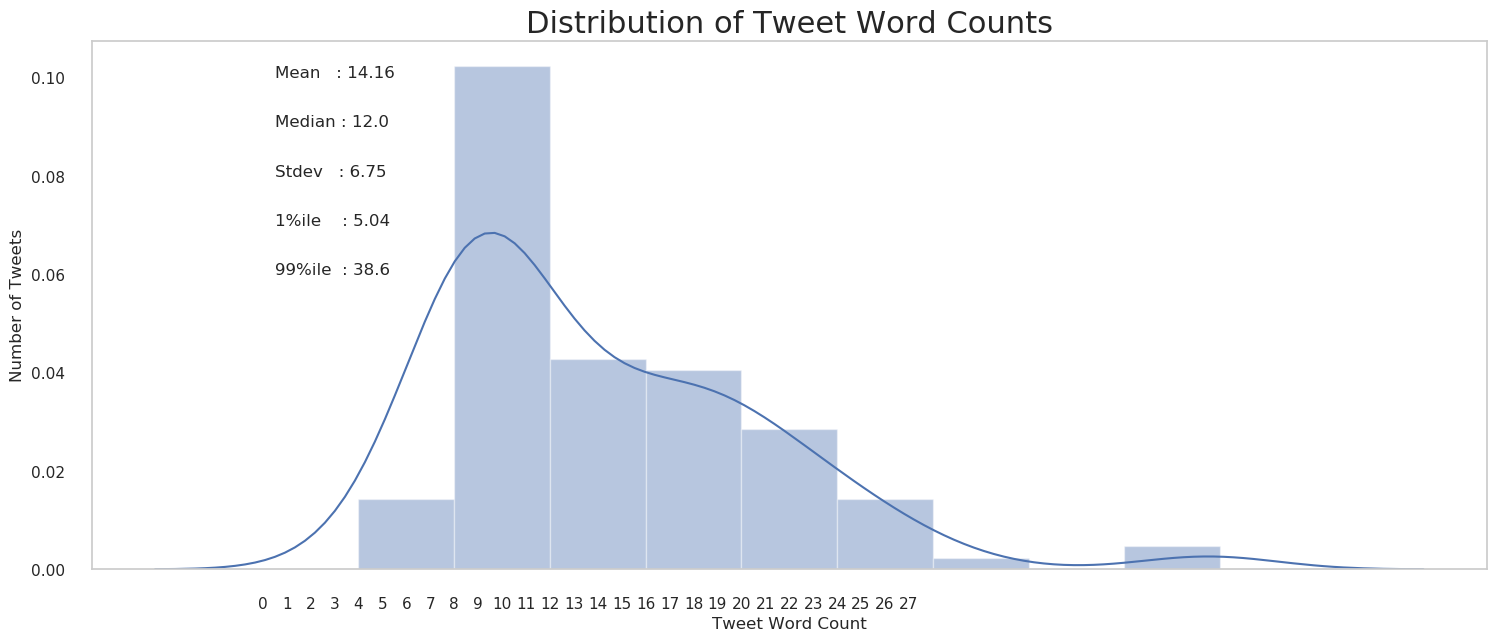

In [81]:
doc_lens = [len(d) for d in df.words]

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(18,7), dpi=100)
sns.distplot(doc_lens)
plt.text(.5, .100, "Mean   : " + str(round(np.mean(doc_lens), 2)))
plt.text(.5, .090, "Median : " + str(round(np.median(doc_lens), 2)))
plt.text(.5, .080, "Stdev   : " + str(round(np.std(doc_lens), 2)))
plt.text(.5, .070, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01), 2)))
plt.text(.5, .060, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99), 2)))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,27,28))
plt.title('Distribution of Tweet Word Counts', fontdict=dict(size=22))
plt.show()

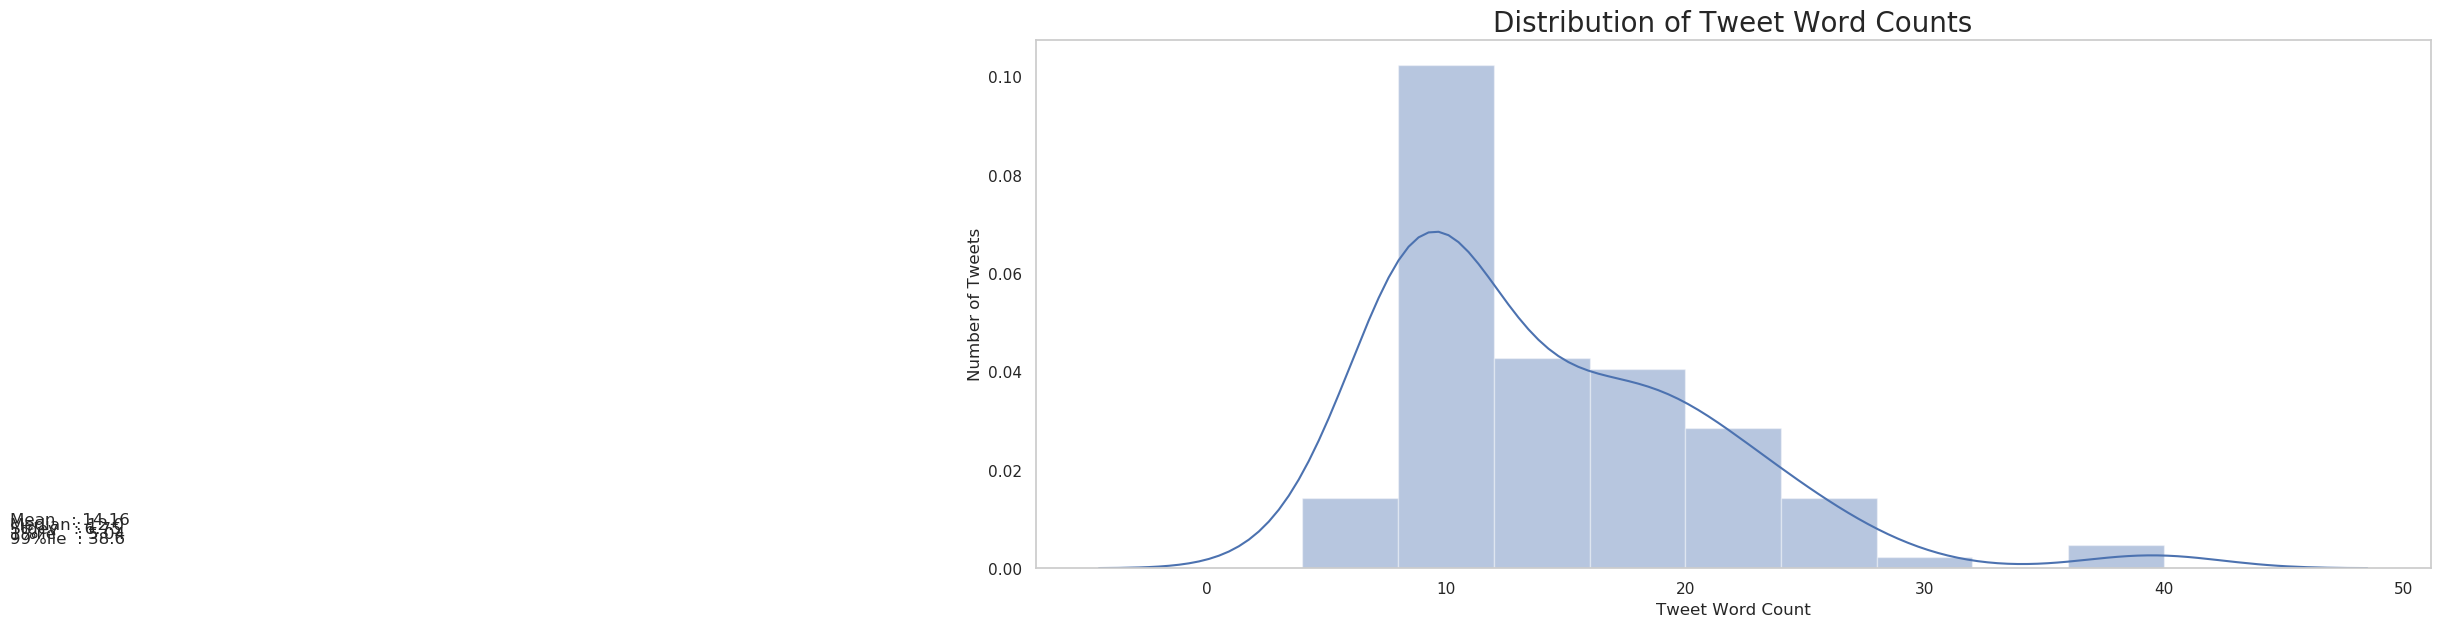

In [82]:
doc_lens = [len(d) for d in df.words]

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(18,7), dpi=100)
sns.distplot(doc_lens)
plt.text(-50, .009, "Mean   : " + str(round(np.mean(doc_lens), 2)))
plt.text(-50, .008, "Median : " + str(round(np.median(doc_lens), 2)))
plt.text(-50, .007, "Stdev   : " + str(round(np.std(doc_lens), 2)))
plt.text(-50, .006, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01), 2)))
plt.text(-50, .005, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99), 2)))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts', fontdict=dict(size=20))
plt.show()


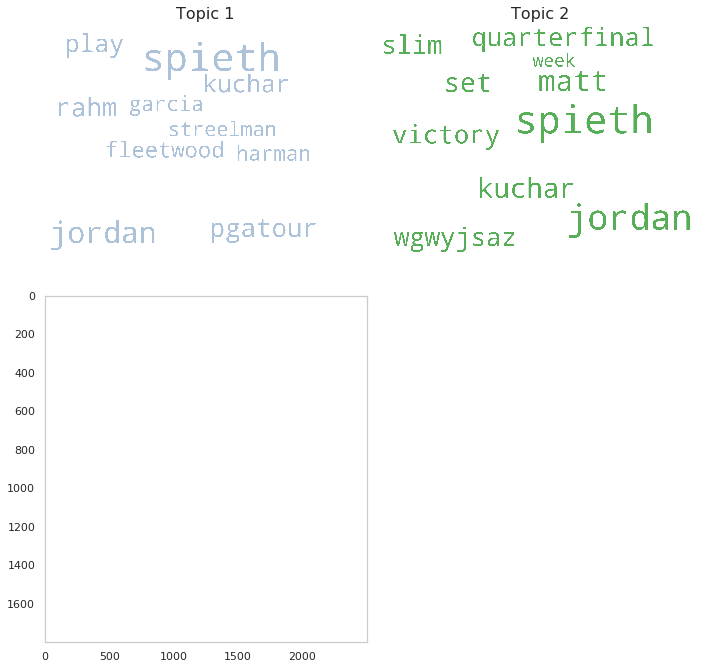

In [83]:
# 1. Wordcloud of Top N words in each topic
import math
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS', fewer colors: 'mcolors.TABLEAU_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    try:
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        continue

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

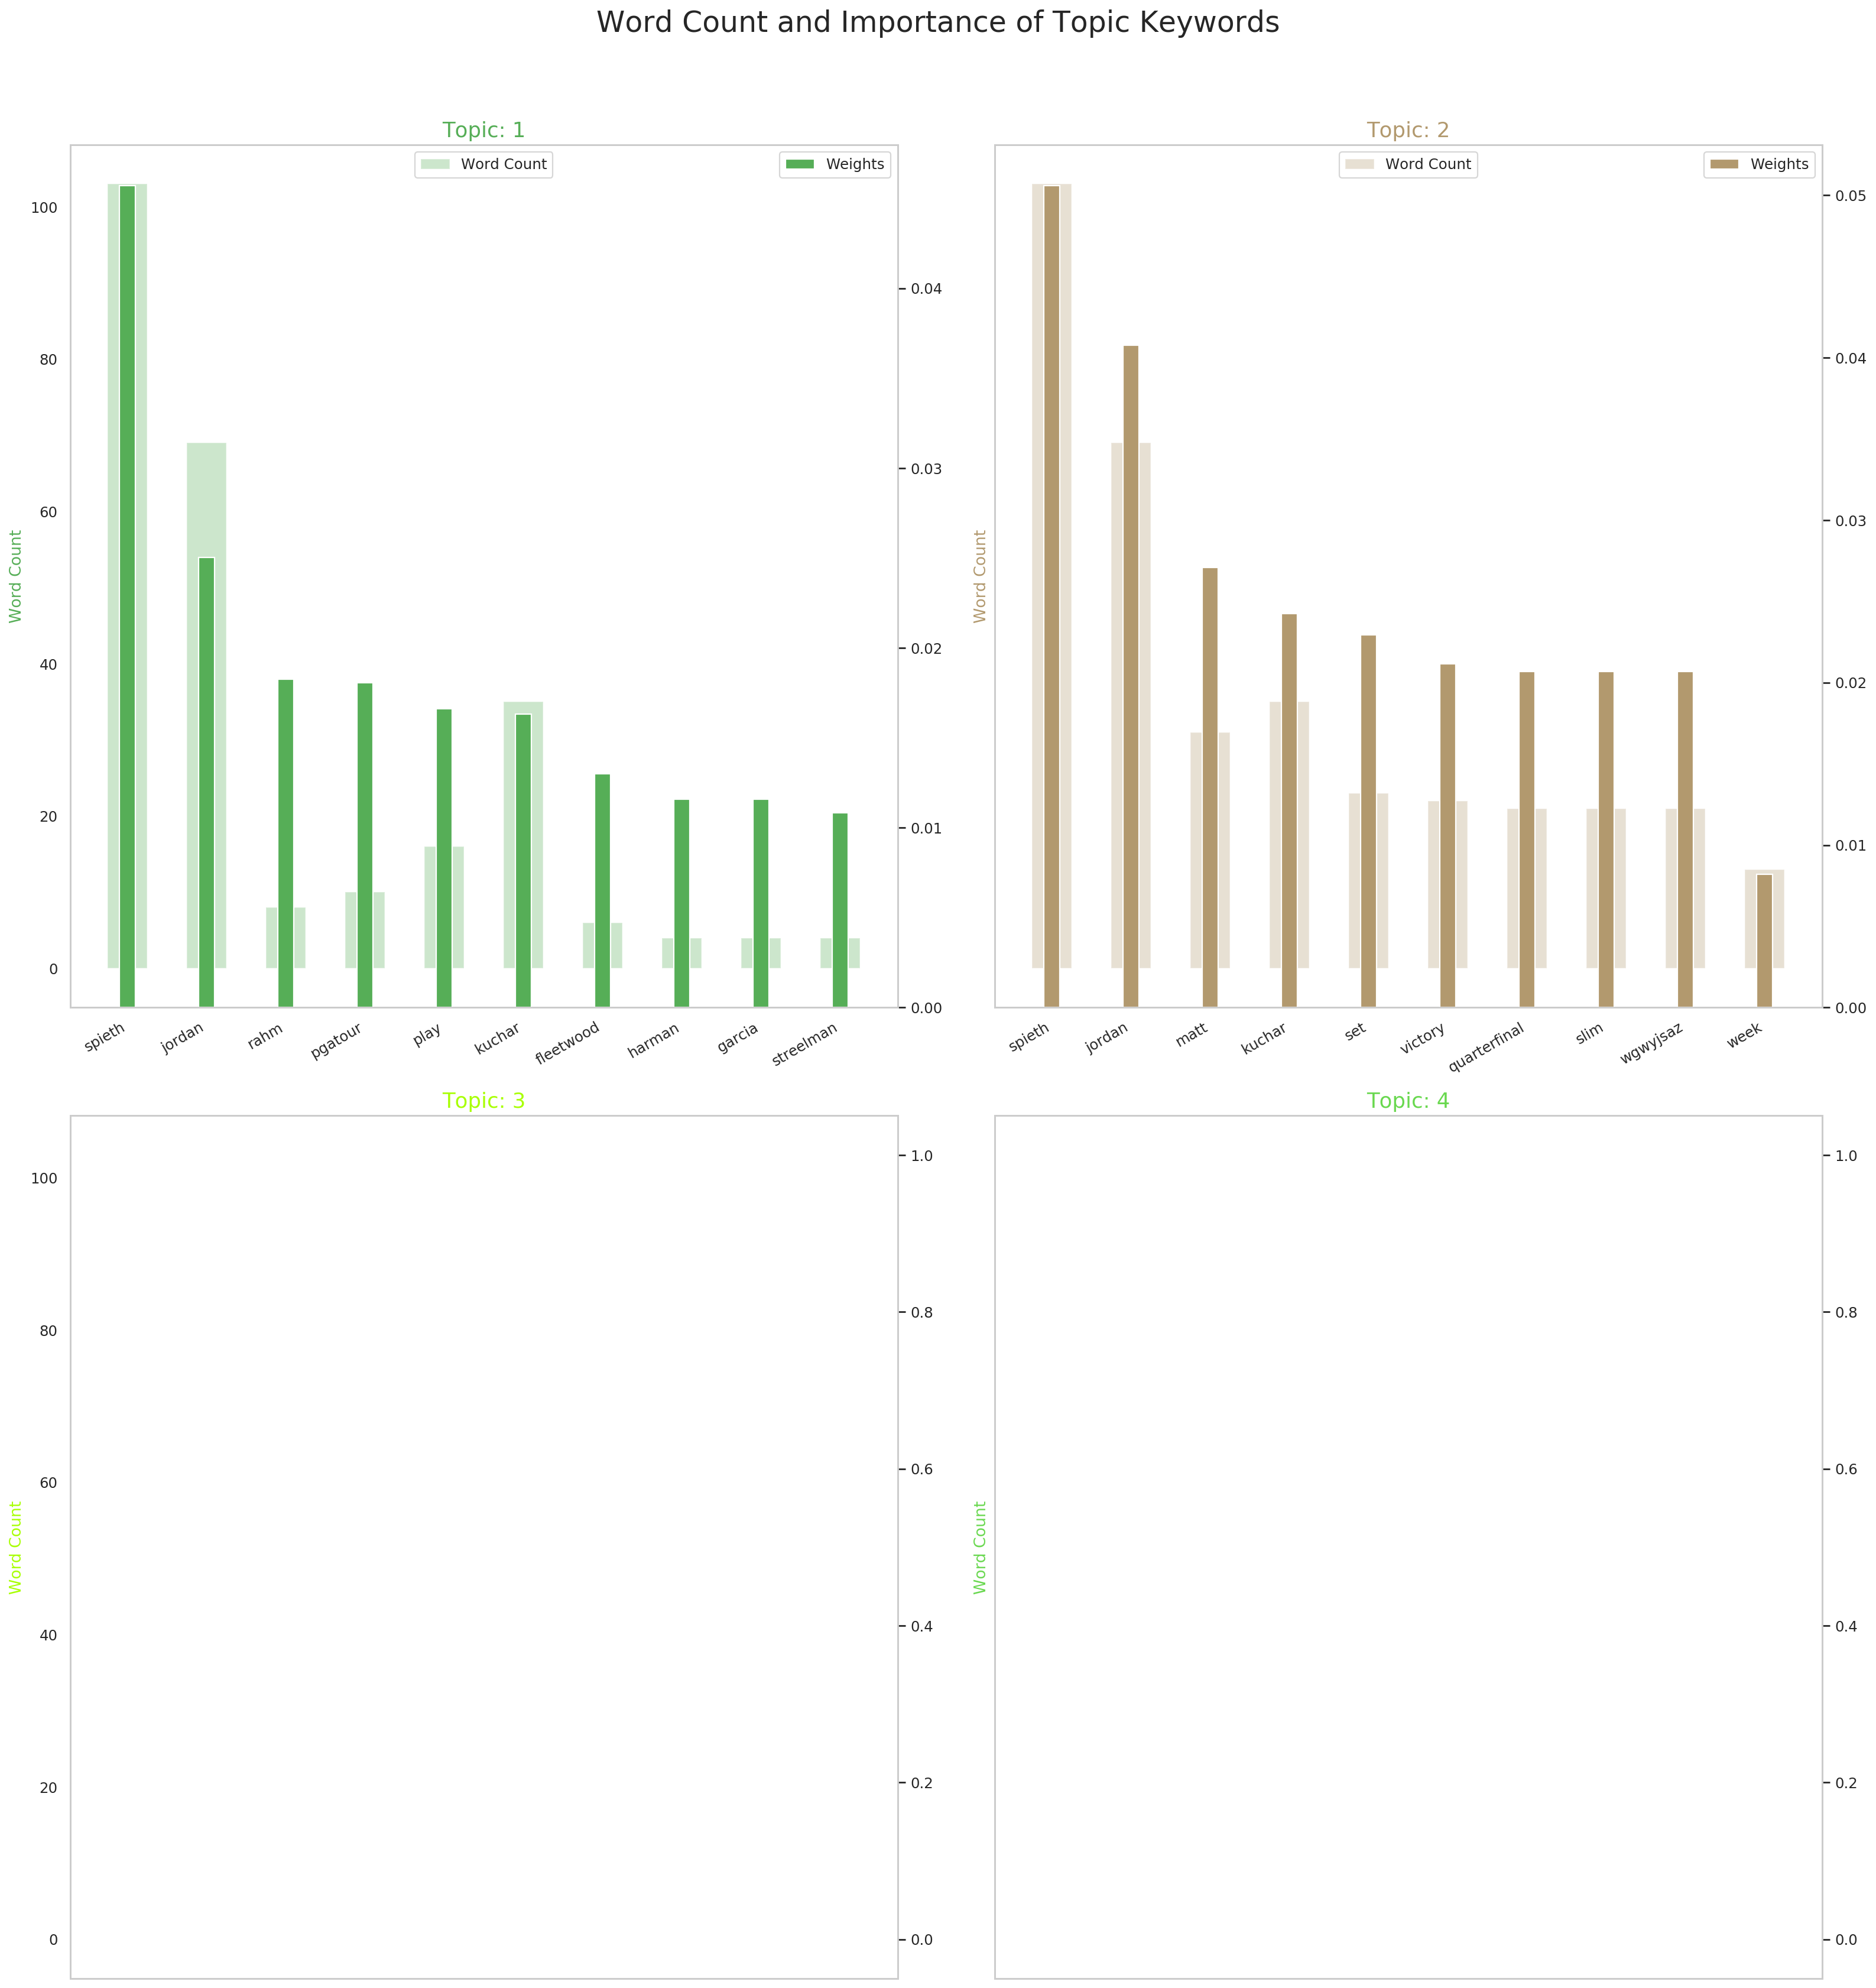

In [84]:
# Bar chart of word counts for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i + 1, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i+1])
    # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i + 1), color=cols[i+1], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i+1, 'word'], rotation=30, horizontalalignment= 'right')
    try:
        ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')
    except:
        pass

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

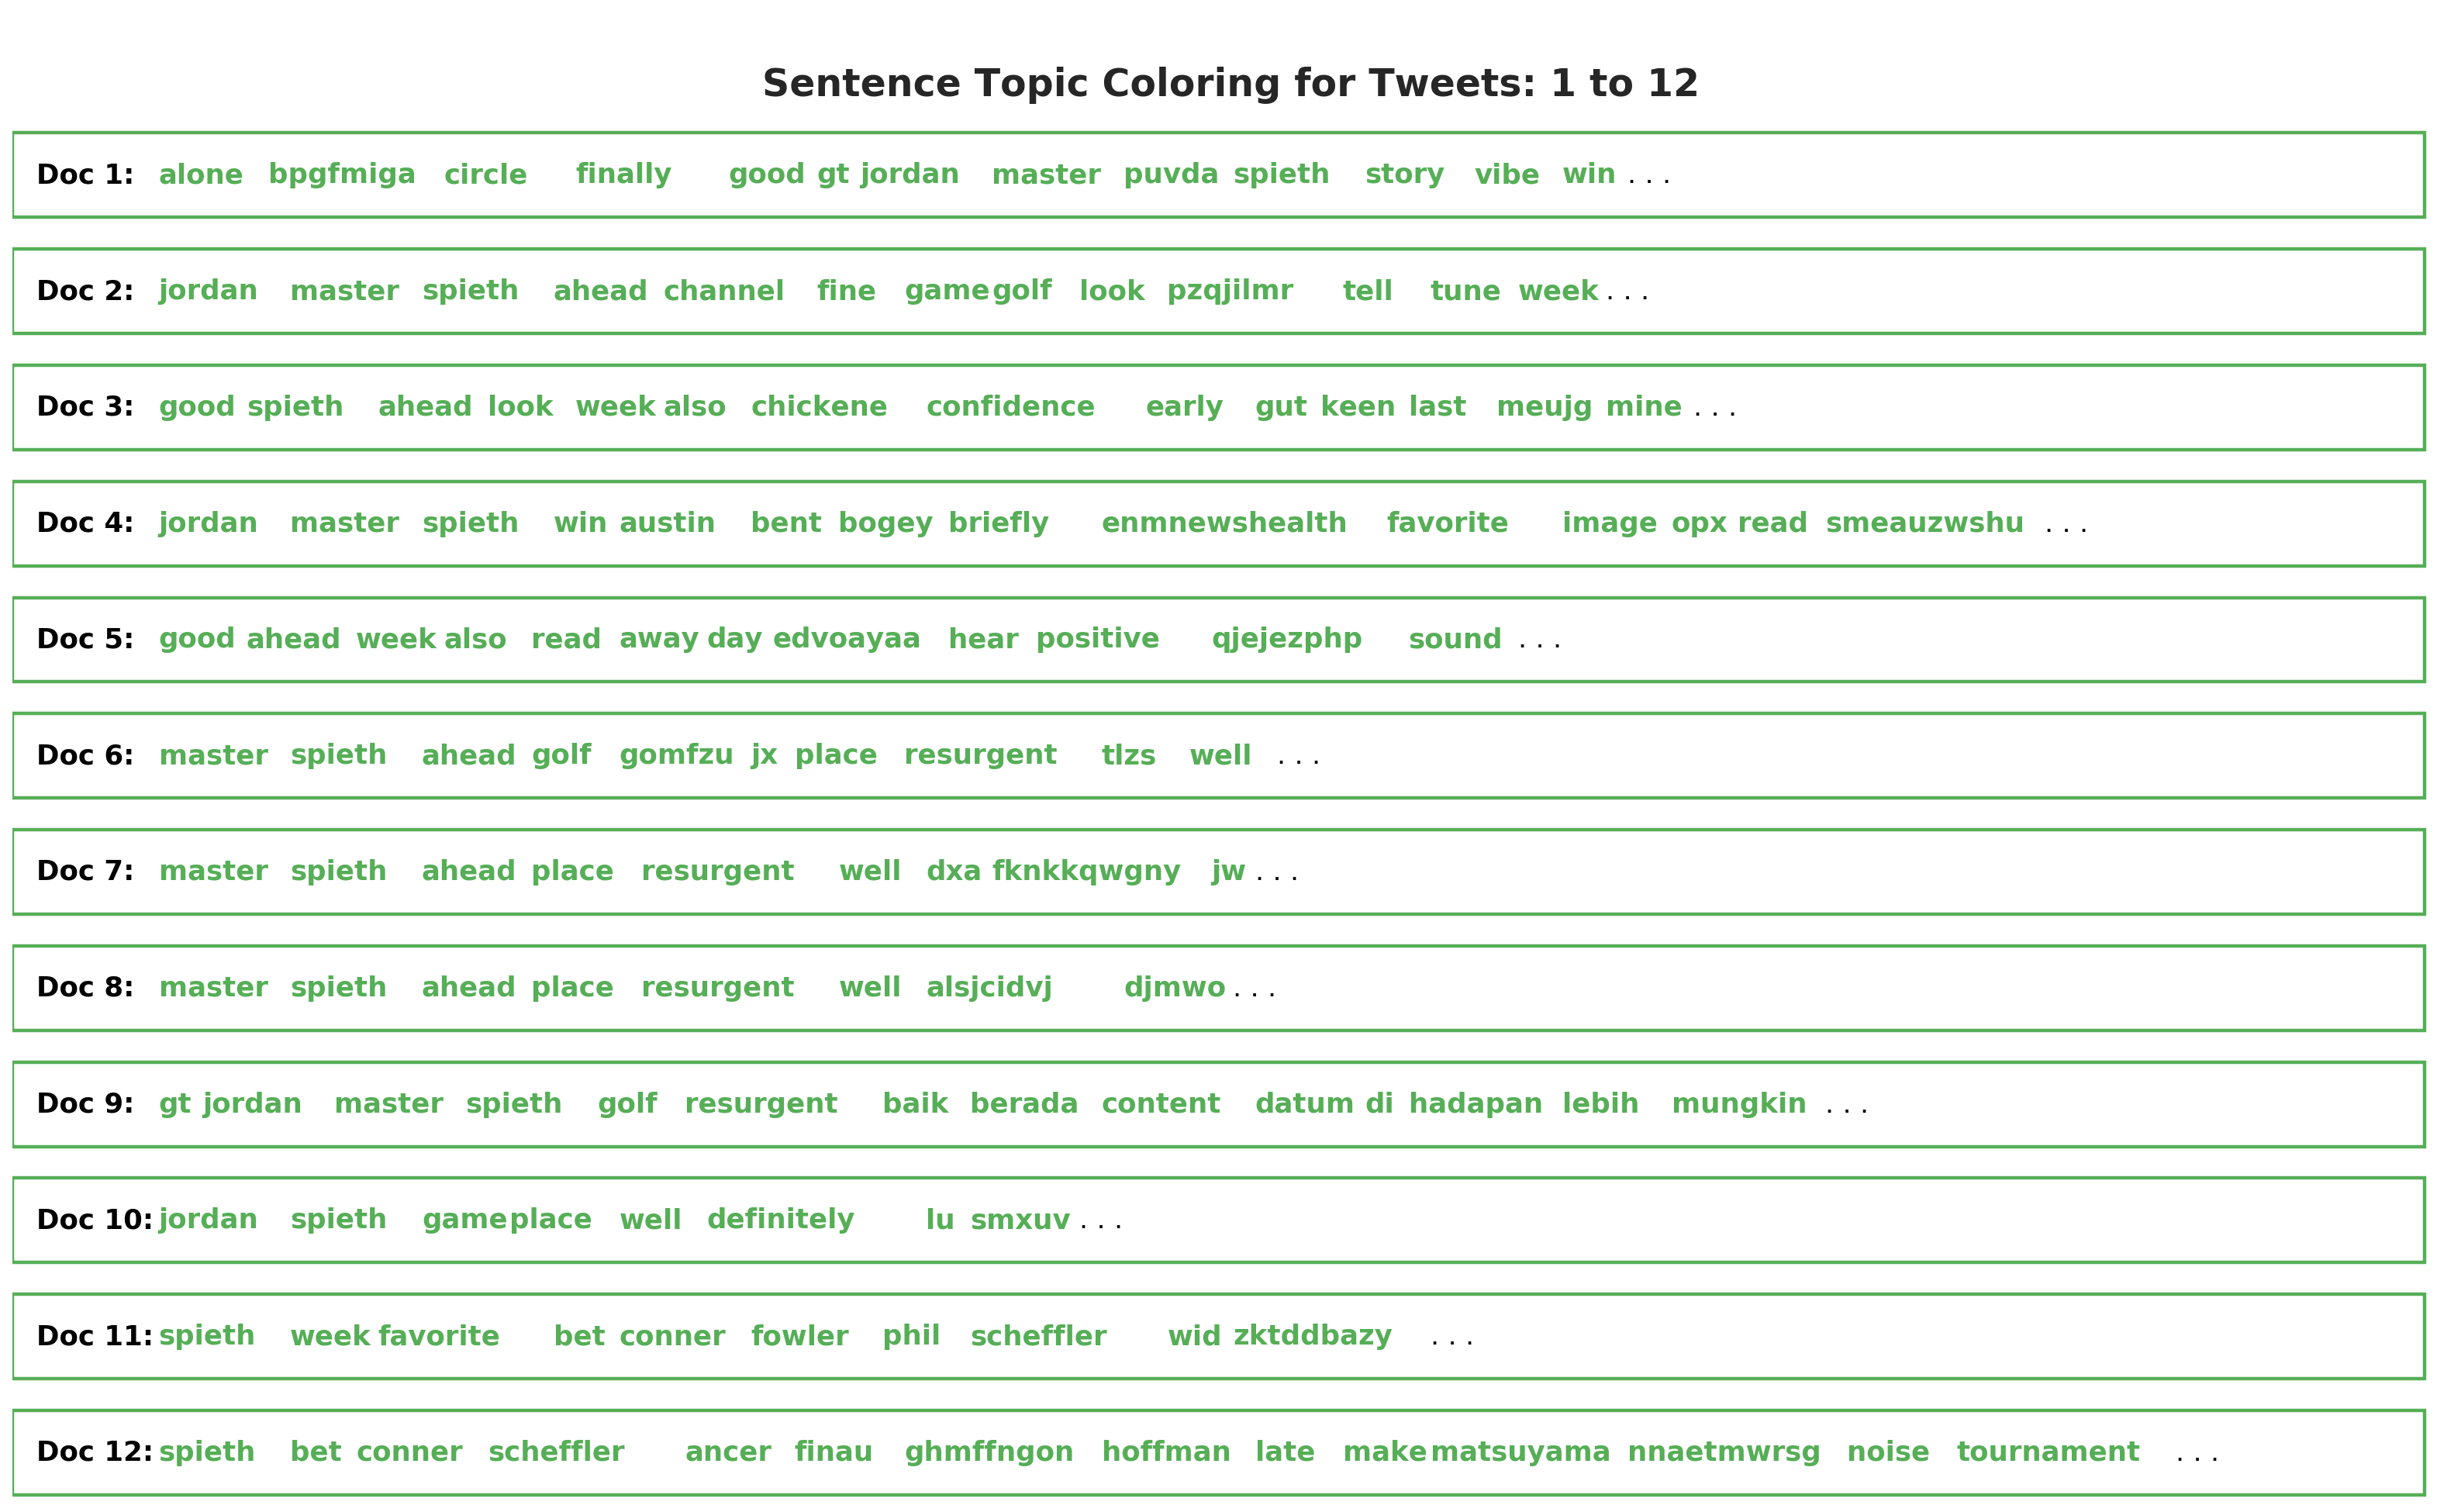

In [85]:
# Sentence Coloring of N Tweets
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.XKCD_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Tweets: ' + str(start + 1) + ' to ' + str(end-1), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [87]:
# Generate a list of the most dominant topics and then the three top keywords in each of those topics
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

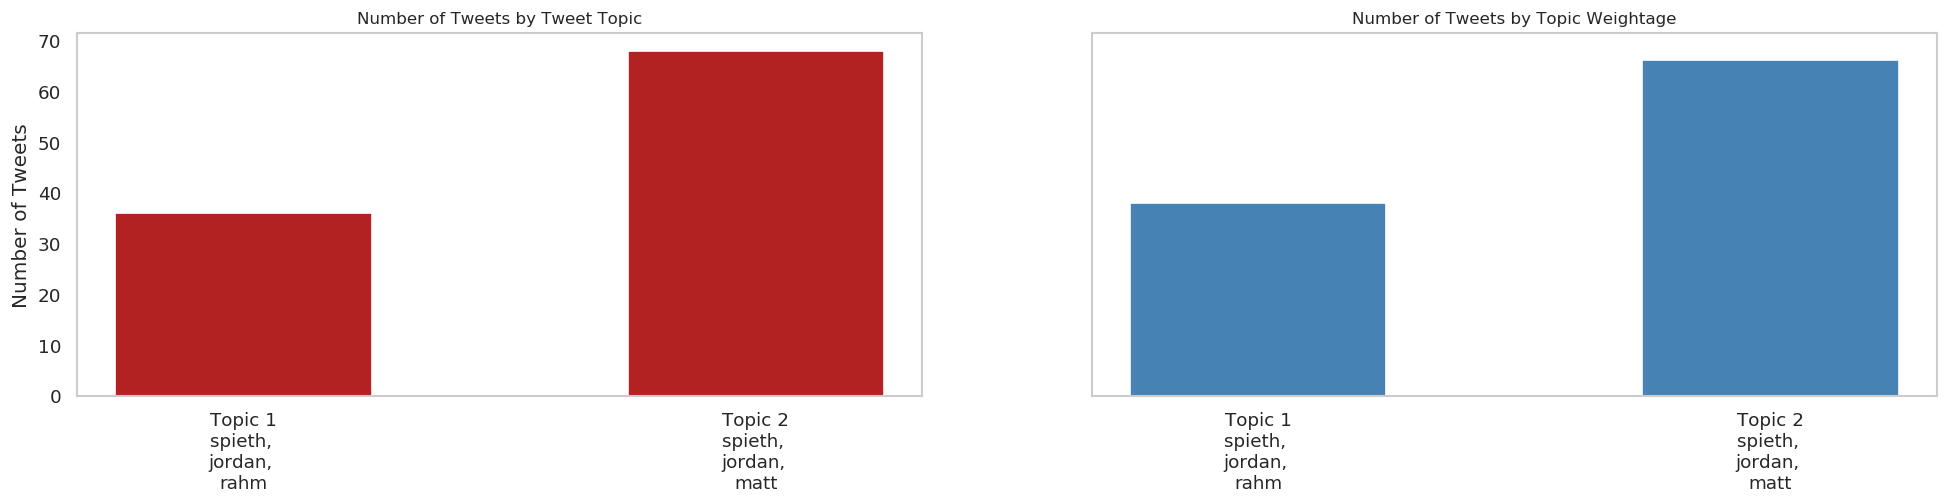

In [88]:
# Two Plots:
#    Num tweets per topic by assigning the document to the topic that has the most weight in that document.
#    Num tweets per topic by summing up the actual weight contribution of each topic to respective documents.

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), dpi=120, sharey=True)

# Topic Distribution by Tweet Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Tweets by Tweet Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Tweets')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Tweets by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [90]:
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 105 samples in 0.000s...
[t-SNE] Computed neighbors for 105 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 105 / 105
[t-SNE] Mean sigma: 0.015842
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.425056
[t-SNE] KL divergence after 700 iterations: 0.024459


Loading BokehJS ...

# Image Processing

In [93]:
def download_image(url, name):
    import requests
    file_type = url.split('.')[-1]
    img_data = requests.get(url).content
    try:
        with open(f'images/{name}.{file_type}', 'wb') as handler:
            handler.write(img_data)
    except:
        print("Could Not Write!")


In [96]:
import pandas as pd
df = pd.read_csv('twitter.csv')
for i, row in enumerate(df.itertuples()):
    #print (row)
    if (str(row[6]) == 'nan'):
        continue
    # print(row)
    if not pd.isnull(row[6]):
        download_image(row[6], row[1])
        print(i, row[6], row[1])

0 https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg 1377090096055263238
1 https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg 1377084502418264075
2 https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg 1377028160496099330
3 https://pbs.twimg.com/media/ExweZP0WUAUoFyI.jpg 1377009006892433413
4 https://pbs.twimg.com/media/Exwc-3eWUAARumh.png 1377007973806014464
5 https://pbs.twimg.com/media/ExwIEf8VEAAmz9A.jpg 1376984460910989313
6 https://pbs.twimg.com/media/ExwB6ISU4AEh95G.jpg 1376977685822382081
7 https://pbs.twimg.com/media/ExwB5GwVcAIbZra.jpg 1376977668638273536
8 https://pbs.twimg.com/media/Exv_2DwUcAErjVn.jpg 1376975419035983872
9 https://pbs.twimg.com/media/Exvvg90WEAAX7Vu.jpg 1376957462876655620
10 https://pbs.twimg.com/media/Exvveb7WQAQU2Pf.jpg 1376957422263209990
11 https://pbs.twimg.com/media/ExvqFdjWYAEtxlx.jpg 1376952842162933761
12 https://pbs.twimg.com/media/Exvon6fWUAovdCb.jpg 1376949886302748679
13 https://pbs.twimg.com/media/ExvhijUXEAE4hrw.jpg 1376945959641419777
14 https://pbs.t

In [97]:
import glob
import boto3
import os
import pandas as pd

bucket = "final-project-bucket"    # replace this with your bucket name
prefix = "photos/twitter" # replace this with the path to your images

In [101]:
#upload the files to the S3 bucket
images = glob.glob("images/*.jpg")
for filename in images:
    boto3.Session().resource('s3').Bucket(bucket).upload_file(filename,f'{prefix}/{os.path.basename(filename)}')


In [102]:
import pandas as pd
df = pd.read_csv('twitter_with_LDA.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)
df.head()

(105, 15)


,id,retweets,likes,replies,quotes,url,text,lang,sensitive,has_media,words,Dominant_topic,Dominant_score,topic_1,topic_2
0,1377090096055263238,1,0,0,0,https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg,“Good vibes” finally circling around Jordan Sp...,en,False,True,"['good', 'vibe', 'finally', 'circle', 'jordan'...",2,0.963763,0.036237,0.963763
1,1377084502418264075,1,14,0,1,https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg,🚨Jordan Spieth told Golf Channel that he’s loo...,en,False,True,"['jordan', 'spieth', 'tell', 'golf', 'channel'...",2,0.958760,0.041240,0.958760
2,1377028160496099330,0,0,0,0,https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg,@OsisAnnie @RobBoltonGolf @valerotxopen @PGATO...,en,False,True,"['good', 'look', 'team', 'mine', 'similar', 'a...",2,0.976059,0.023941,0.976059
3,1377009006892433413,0,0,0,0,https://pbs.twimg.com/media/ExweZP0WUAUoFyI.jpg,"AUSTIN, Texas (AP) - Jordan Spieth tapped in f...",en,False,True,"['austin', 'texas', 'jordan', 'spieth', 'tap',...",2,0.973178,0.026822,0.973178
4,1377007973806014464,0,0,0,0,https://pbs.twimg.com/media/Exwc-3eWUAARumh.png,Good to hear @JordanSpieth @UnderArmour soundi...,en,False,True,"['good', 'hear', 'sound', 'positive', 'ahead',...",2,0.959704,0.040296,0.959704


In [103]:
#s3 = boto3.resource('s3')
#my_bucket = s3.Bucket(bucket)
#files = my_bucket.objects.filter(Prefix=prefix)
#client = boto3.client('rekognition')

dfFaces = pd.DataFrame([])
i=0

for row in df.itertuples():
    if (str(row[6]) == 'nan'):
        continue
    file = f"{row[1]}" # Using ID as file name
    print(f"row 6 {row[6]}")
    extension = f"{row[6].split('.')[-1]}"
    print(f"Processing TweetID - {file}")
    if not pd.isnull(file):
        #print(i, row[1], file, f"{prefix}/{row[1]}.{file.split('.')[-1]}")


        if extension == 'jpg':
            # call rekognition for this next file
            response = client.detect_faces(
                Image={
                    'S3Object': {
                        'Bucket': bucket,
                        'Name': f"{prefix}/{file}.{extension}"
                    }
                },
                Attributes=[
                    'ALL',
                ]
            )

            # now add all of the facial features for every person found in the photo
            for fd in response["FaceDetails"]:    
                i=i+1
                dfFaces.loc[i,'TweetID'] = file
                dfFaces.loc[i,'PersonID'] = i
                dfFaces.loc[i,'AgeRange-Low'] = fd["AgeRange"]["Low"]
                dfFaces.loc[i,'AgeRange-High'] = fd["AgeRange"]["High"]
                dfFaces.loc[i,'Smile'] = fd["Smile"]["Value"]
                dfFaces.loc[i,'Gender'] = fd["Gender"]["Value"]
                dfFaces.loc[i,'Emotion'] = fd["Emotions"][0]["Type"] #get dominant emotion
                dfFaces.loc[i,'Emotion-Confidence'] = fd["Emotions"][0]["Confidence"] #get dominant emotion


row 6 https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg
Processing TweetID - 1377090096055263238
row 6 https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg
Processing TweetID - 1377084502418264075
row 6 https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg
Processing TweetID - 1377028160496099330
row 6 https://pbs.twimg.com/media/ExweZP0WUAUoFyI.jpg
Processing TweetID - 1377009006892433413
row 6 https://pbs.twimg.com/media/Exwc-3eWUAARumh.png
Processing TweetID - 1377007973806014464
row 6 https://pbs.twimg.com/media/ExwIEf8VEAAmz9A.jpg
Processing TweetID - 1376984460910989313
row 6 https://pbs.twimg.com/media/ExwB6ISU4AEh95G.jpg
Processing TweetID - 1376977685822382081
row 6 https://pbs.twimg.com/media/ExwB5GwVcAIbZra.jpg
Processing TweetID - 1376977668638273536
row 6 https://pbs.twimg.com/media/Exv_2DwUcAErjVn.jpg
Processing TweetID - 1376975419035983872
row 6 https://pbs.twimg.com/media/Exvvg90WEAAX7Vu.jpg
Processing TweetID - 1376957462876655620
row 6 https://pbs.twimg.com/media/Exvveb7WQAQU2Pf.

In [107]:
dfFaceSummary = pd.DataFrame([])

#summarize stats per file
#aggregate functions include min, max, mean, count, and more.
dfFaceSummary['Count-People'] = dfFaces.groupby('TweetID')['PersonID'].count()
dfFaceSummary['Avg-AgeRange-Low'] = dfFaces.groupby('TweetID')['AgeRange-Low'].min()
dfFaceSummary['Avg-AgeRange-High'] = dfFaces.groupby('TweetID')['AgeRange-High'].max()
dfFaceSummary['Count-Smile'] = dfFaces[dfFaces['Smile']==True].groupby('TweetID')['Smile'].count()
dfFaceSummary['Count-Smile'] = dfFaceSummary['Count-Smile'].fillna(0)
dfFaceSummary['Percent-Smile'] = dfFaceSummary['Count-Smile']/dfFaceSummary['Count-People']
dfFaceSummary['Percent-Smile'] = dfFaceSummary['Percent-Smile'].fillna(0)

dfFaceSummary = dfFaceSummary.merge(dfFaces.groupby('TweetID')['Emotion'].value_counts().unstack().fillna(0), on='TweetID')
dfFaceSummary = dfFaceSummary.merge(dfFaces.groupby('TweetID')['Gender'].value_counts().unstack().fillna(0), on='TweetID')

#print out 
dfFaceSummary


,Count-People,Avg-AgeRange-Low,Avg-AgeRange-High,Count-Smile,Percent-Smile,ANGRY,CALM,CONFUSED,FEAR,HAPPY,SAD,SURPRISED,Female,Male
TweetID,,,,,,,,,,,,,,
1375714494140325888,1,22.0,34.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1375734367289536516,2,23.0,55.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
1375749496479625218,1,26.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1375757496808304640,1,32.0,48.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1375772104164007936,1,24.0,38.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376977685822382081,1,22.0,34.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1376984460910989313,1,22.0,34.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1377028160496099330,6,22.0,50.0,6.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,6.0


In [108]:
#the tweet id is an object, so we need to convert it to the same data type as our id
dfFaceSummary.index = dfFaceSummary.index.astype(int)

#Now merge the frames together
df = df.merge(dfFaceSummary, left_on='id', right_on='TweetID')
df

,id,retweets,likes,replies,quotes,url,text,lang,sensitive,has_media,...,Percent-Smile,ANGRY,CALM,CONFUSED,FEAR,HAPPY,SAD,SURPRISED,Female,Male
0,1377090096055263238,1,0,0,0,https://pbs.twimg.com/media/ExxoAelVgAM_AVn.jpg,“Good vibes” finally circling around Jordan Sp...,en,False,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1377084502418264075,1,14,0,1,https://pbs.twimg.com/media/ExxjDfuWgAAIw6R.jpg,🚨Jordan Spieth told Golf Channel that he’s loo...,en,False,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1377028160496099330,0,0,0,0,https://pbs.twimg.com/media/ExwvipHUUAIdXhh.jpg,@OsisAnnie @RobBoltonGolf @valerotxopen @PGATO...,en,False,True,...,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,6.0
3,1376984460910989313,0,0,0,0,https://pbs.twimg.com/media/ExwIEf8VEAAmz9A.jpg,Golf: Resurgent Spieth 'in a better place' ahe...,en,False,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1376977685822382081,0,0,0,0,https://pbs.twimg.com/media/ExwB6ISU4AEh95G.jpg,Resurgent Spieth 'in a better place' ahead of ...,en,False,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1375772104164007936,4,72,2,1,https://pbs.twimg.com/media/Exe5cA2WEAUG6f6.jpg,Jordan Spieth is set for a challenging match a...,en,False,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
77,1375757496808304640,0,0,0,0,https://pbs.twimg.com/media/ExesJytW8AQvUlm.jpg,#JORDAN #SPIETH #Saves #Par after #Crazy ...\n...,en,False,True,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78,1375749496479625218,2,56,0,1,https://pbs.twimg.com/media/Exek36OWUAQJ2jc.jpg,"The Jordan Spieth redemption tour continues, w...",en,False,True,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
79,1375734367289536516,1,27,0,0,https://pbs.twimg.com/media/ExeXHafWgAIqT-h.jpg,Jordan Spieth will play in San Antonio at Vale...,en,False,True,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [110]:
#now save this out to a new csv
df.to_csv('twitter_with_LDA_and_image_data.csv', index=False)

# Data Modeling
This section contains Python code that builds and trains a model and then uses it to make predictions.

In [111]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regression algorithm
from sklearn.ensemble import GradientBoostingRegressor # Import XGBoost algorithm 
from sklearn.model_selection import train_test_split # Import train_test_split function
# for a completelist of available algorithms: https://scikit-learn.org/stable/supervised_learning.html
# Which one should I use?: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

df = pd.read_csv('twitter_with_LDA_and_image_data.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)

# Determine what you want to predict:
label = 'retweets'


(81, 29)


In [77]:
# Print out the columns so that we can identify which ones we want to drop (e.g. unique identifiers, original text before processing, image file names, dates)
for col in df.columns:
    print(f'\'{col}\', ', end="")

drop_list = ['id', 'created_at', 'url', 'text', 'words', 'File', 'PersonID', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9']


'id', 'retweets', 'likes', 'replies', 'quotes', 'url', 'text', 'lang', 'sensitive', 'has_media', 'words', 'Dominant_topic', 'Dominant_score', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 

In [78]:
# Eliminate anything remaining in the drop list without throwing an error in case we removed it earlier
for col in df.columns:
    if col in drop_list:
        try:
            df.drop(columns=[col], inplace=True)
        except:
            continue

In [79]:
df.head()
#df.dtypes

df.dropna(inplace=True)       # Remove any rows with null values
print(f'Records: {len(df)}')  # Count and print the number of rows remaining

df['Dominant_topic'] = df['Dominant_topic'].astype('object') # Topics are categorical so this needs to be modified since it's a number


Records: 17


In [80]:
# Create dummy codes for all features and not the label
for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df = pd.get_dummies(df, columns=[col], prefix=col)

# Eliminate columns with only one unique value
for col in df.columns:
    if (df[col].nunique() < 2):
        try:
            df.drop(columns=[col], inplace=True)
        except:
            continue

df

,retweets,likes,replies,has_media,Dominant_score,lang_en,lang_ht,lang_no,Dominant_topic_1,Dominant_topic_2,Dominant_topic_3,Dominant_topic_5,Dominant_topic_7,Dominant_topic_9
0,1,0,0,False,0.925922,1,0,0,1,0,0,0,0,0
1,5,0,0,False,0.925925,0,1,0,1,0,0,0,0,0
2,1,0,0,False,0.777703,1,0,0,0,0,0,0,1,0
3,592,0,0,True,0.851839,1,0,0,0,0,1,0,0,0
4,0,0,0,False,0.851838,1,0,0,0,0,1,0,0,0
5,0,0,0,False,0.919185,0,0,1,0,1,0,0,0,0
6,592,0,0,True,0.851839,1,0,0,0,0,1,0,0,0
7,592,0,0,True,0.851839,1,0,0,0,0,1,0,0,0
8,592,0,0,True,0.851838,1,0,0,0,0,1,0,0,0
9,592,0,0,True,0.851839,1,0,0,0,0,1,0,0,0


In [112]:
# Split dataset in features and target variable

y = df[label] # Label
X = df.drop(columns=[label]) # Features
X = X.select_dtypes(np.number)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X_train.head()

,likes,replies,quotes,Dominant_topic,Dominant_score,topic_1,topic_2,Count-People,Avg-AgeRange-Low,Avg-AgeRange-High,...,Percent-Smile,ANGRY,CALM,CONFUSED,FEAR,HAPPY,SAD,SURPRISED,Female,Male
61,0,0,0,2,0.945692,0.054309,0.945692,1,28.0,44.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
73,2,1,0,1,0.903611,0.903611,0.096389,1,36.0,52.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
67,135,30,6,2,0.945691,0.054309,0.945691,1,28.0,44.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
26,15,1,3,1,0.966451,0.966451,0.033549,1,31.0,47.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
79,27,0,0,1,0.944160,0.944160,0.055840,2,23.0,55.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [114]:
# This Linear Regression is only for model interpretation purposes

import statsmodels.api as sm

# Run the multiple linear regression model
model = sm.OLS(y, X)
results = model.fit()

# View results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               retweets   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.700
Method:                 Least Squares   F-statistic:                              10.94
Date:                Wed, 31 Mar 2021   Prob (F-statistic):                    2.46e-13
Time:                        05:18:21   Log-Likelihood:                         -264.14
No. Observations:                  81   AIC:                                      566.3
Df Residuals:                      62   BIC:                                      611.8
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [115]:
# Create Decision Tree regressor object
clf = DecisionTreeRegressor()

# Train Decision Tree regressor
clf = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clf.predict(X_test)


In [116]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

,Actual,Predicted
63,23,23.0
27,0,0.0
31,3,3.0
69,0,1.0
46,23,23.0
47,23,23.0
53,23,23.0
76,4,3.0
39,2,1.0
74,0,0.0


In [117]:
# Import scikit-learn metrics module. See complete list of Classification metrics here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn import metrics

print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

R squared:	0.6437104511600993
MAE:		1.8
RMSE:		7.815369473031969


In [118]:
# Create XGBoost regressor object
clr = GradientBoostingRegressor()

# Train Decision Tree regression
clr = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clr.predict(X_test)


In [119]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

,Actual,Predicted
63,23,23.0
27,0,0.0
31,3,6.0
69,0,1.0
46,23,23.0
47,23,23.0
53,23,23.0
76,4,2.0
39,2,1.0
74,0,0.0


In [120]:
from sklearn import metrics

print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

R squared:	0.6409105332910234
MAE:		1.96
RMSE:		7.846018098373213


In [121]:
import pickle

# Save the model with the highest fit metric
pickle.dump(clr, open('stored_model.sav', 'wb'))  # OPTION 1: pickle

In [122]:
# ...some time later

import pickle
import numpy as np

# OPTION 1: Using pickle
# load the model from 'stored_model.sav'
loaded_model = pickle.load(open('stored_model.sav', 'rb'))

# for a single prediction, enter a row of data and reshape into numpy array
case = X_test.iloc[0]
print(f'Single prediction:\t{loaded_model.predict(np.array(case).reshape(1, -1))[0]}\n\n{case}\n')

# for a batch prediction, enter a Pandas DataFrame or a Numpy array of arrays
predictions = loaded_model.predict(X_test) 
batch_results = pd.DataFrame({'Actual':y_test, 'Predicted':predictions, 'Diff':(predictions - y_test)})
print(f'MAE:\t{batch_results.Diff.abs().mean()}\n')
batch_results.head(5)

Single prediction:	23.0

likes                 0.000000
replies               0.000000
quotes                0.000000
Dominant_topic        2.000000
Dominant_score        0.945691
topic_1               0.054309
topic_2               0.945691
Count-People          1.000000
Avg-AgeRange-Low     28.000000
Avg-AgeRange-High    44.000000
Count-Smile           0.000000
Percent-Smile         0.000000
ANGRY                 0.000000
CALM                  0.000000
CONFUSED              1.000000
FEAR                  0.000000
HAPPY                 0.000000
SAD                   0.000000
SURPRISED             0.000000
Female                0.000000
Male                  1.000000
Name: 63, dtype: float64

MAE:	1.96



,Actual,Predicted,Diff
63,23,23.0,0.0
27,0,0.0,0.0
31,3,6.0,3.0
69,0,1.0,1.0
46,23,23.0,0.0
